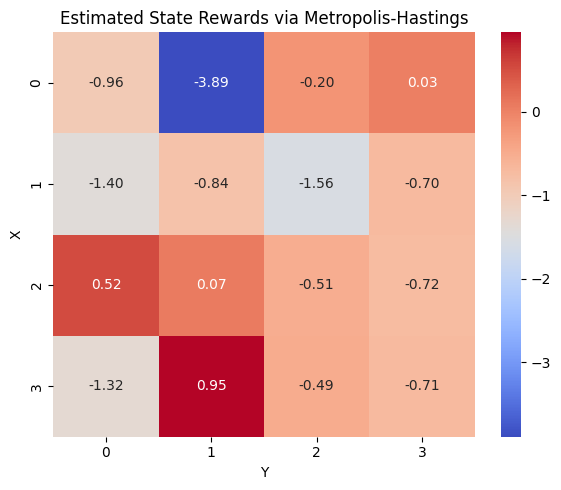

In [3]:
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# GridWorld parameters
grid_size = 4
states = grid_size * grid_size
actions = 4  # up, down, left, right
gamma = 0.95
true_reward = -1.0

# Define possible actions
def get_next_state(s, a):
    x, y = divmod(s, grid_size)
    if a == 0 and x > 0:
        x -= 1
    elif a == 1 and x < grid_size - 1:
        x += 1
    elif a == 2 and y > 0:
        y -= 1
    elif a == 3 and y < grid_size - 1:
        y += 1
    return x * grid_size + y

# Simulate an environment with uncertain rewards
np.random.seed(0)
env_rewards = np.random.normal(loc=true_reward, scale=0.5, size=states)

# Sample trajectories under a fixed random policy
def sample_trajectory(length=10):
    s = np.random.randint(0, states)
    trajectory = []
    for _ in range(length):
        a = np.random.choice(actions)
        s_next = get_next_state(s, a)
        r = env_rewards[s_next]
        trajectory.append((s, a, r))
        s = s_next
    return trajectory

# Define posterior (unnormalized) probability for a reward function
def posterior_log_likelihood(rewards, trajectory, sigma=0.5):
    log_likelihood = 0
    for (s, a, r_obs) in trajectory:
        r_model = rewards[s]
        log_likelihood += -((r_obs - r_model) ** 2) / (2 * sigma**2)
    return log_likelihood

# Metropolis-Hastings sampling for reward function
def metropolis_hastings(initial_rewards, trajectory, iterations=500):
    current = initial_rewards.copy()
    samples = []
    for _ in range(iterations):
        proposal = current + np.random.normal(0, 0.1, size=states)
        accept_ratio = np.exp(posterior_log_likelihood(proposal, trajectory) -
                              posterior_log_likelihood(current, trajectory))
        if np.random.rand() < min(1, accept_ratio):
            current = proposal
        samples.append(current.copy())
    return np.array(samples)

# Run simulation
trajectory = sample_trajectory(length=20)
init_rewards = np.random.normal(-1.0, 1.0, size=states)
samples = metropolis_hastings(init_rewards, trajectory, iterations=300)

# Compute mean estimated reward per state
mean_rewards = np.mean(samples[-100:], axis=0).reshape((grid_size, grid_size))

# Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(mean_rewards, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Estimated State Rewards via Metropolis-Hastings")
plt.xlabel("Y")
plt.ylabel("X")
plt.tight_layout()
plt.show()

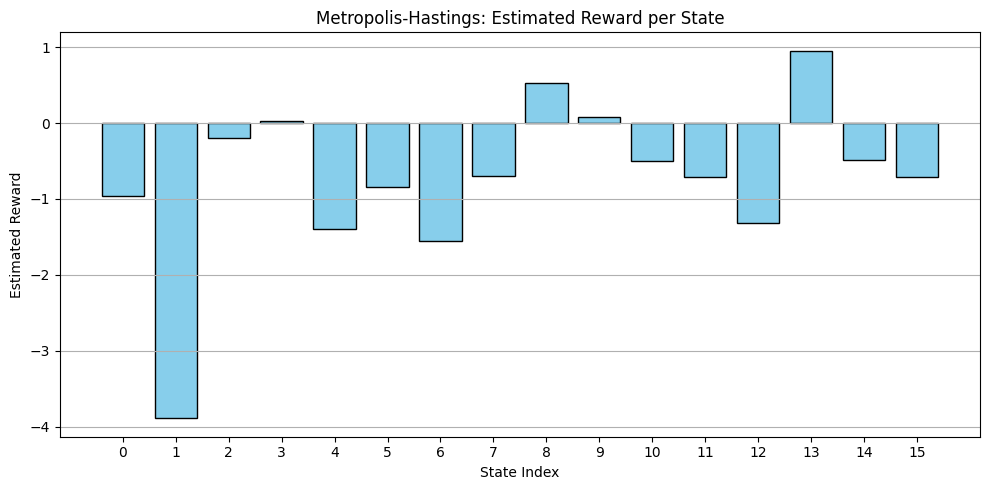

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are defined from earlier BRL + MH steps:
# - samples: array of sampled reward vectors from MH
# - states: total number of states (e.g., 16 for 4x4 grid)

# Compute the mean reward per state from the last 100 samples
mean_rewards_flat = np.mean(samples[-100:], axis=0)
state_indices = np.arange(states)

# Plot histogram of estimated rewards per state
plt.figure(figsize=(10, 5))
plt.bar(state_indices, mean_rewards_flat, color='skyblue', edgecolor='black')
plt.xlabel("State Index")
plt.ylabel("Estimated Reward")
plt.title("Metropolis-Hastings: Estimated Reward per State")
plt.xticks(state_indices)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

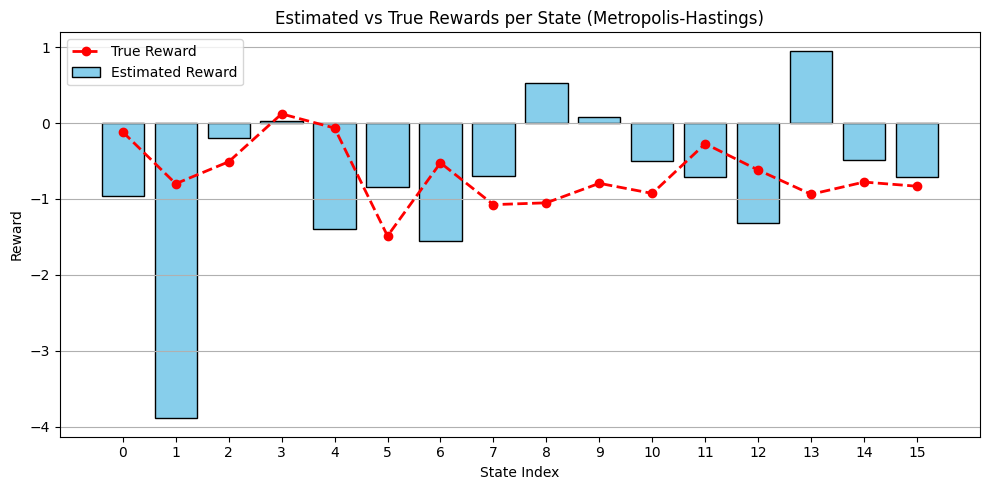

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assume these are defined from your previous code:
# samples: array of sampled reward vectors from MH
# env_rewards: the true reward vector from the simulated environment
# states: total number of states (e.g., 16 for 4x4 grid)

# Compute mean estimated reward per state
mean_rewards_flat = np.mean(samples[-100:], axis=0)
state_indices = np.arange(states)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(state_indices, mean_rewards_flat, color='skyblue', edgecolor='black', label='Estimated Reward')
plt.plot(state_indices, env_rewards, color='red', marker='o', linestyle='--', linewidth=2, label='True Reward')
plt.xlabel("State Index")
plt.ylabel("Reward")
plt.title("Estimated vs True Rewards per State (Metropolis-Hastings)")
plt.xticks(state_indices)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

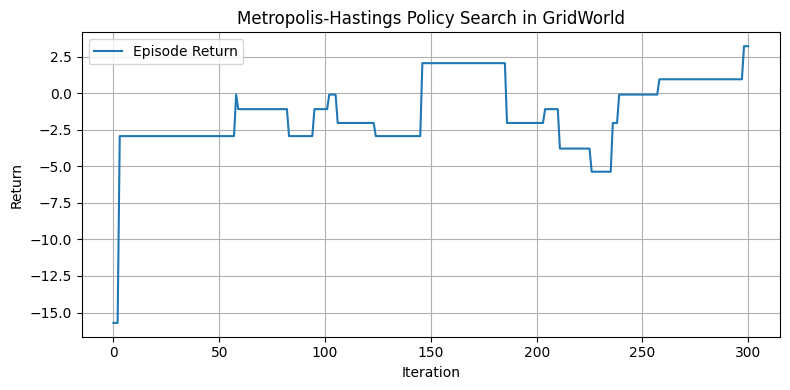

In [6]:
# metropolitan hastings policy search in gridwrold
#Metropolis-Hastings policy search in GridWorld, using softmax policies and episodic return evaluation:

import numpy as np
import matplotlib.pyplot as plt

# GridWorld parameters
grid_size = 4
num_states = grid_size * grid_size
num_actions = 4  # up, down, left, right
gamma = 0.95

# Convert state index to (x, y) coordinates
def state_to_xy(state):
    return divmod(state, grid_size)

# Convert (x, y) to state index
def xy_to_state(x, y):
    return x * grid_size + y

# Deterministic transition function
def get_next_state(state, action):
    x, y = state_to_xy(state)
    if action == 0 and x > 0: x -= 1      # Up
    elif action == 1 and x < grid_size - 1: x += 1  # Down
    elif action == 2 and y > 0: y -= 1    # Left
    elif action == 3 and y < grid_size - 1: y += 1  # Right
    return xy_to_state(x, y)

# Reward function: +10 at terminal state, -1 otherwise
def reward_function(state):
    return 10 if state == num_states - 1 else -1

# Softmax function for action selection
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

# Simulate an episode return using current policy logits
def rollout(policy_params, start=0, max_steps=30):
    state = start
    total_return = 0
    discount = 1.0
    for _ in range(max_steps):
        probs = softmax(policy_params[state])
        action = np.random.choice(num_actions, p=probs)
        next_state = get_next_state(state, action)
        reward = reward_function(next_state)
        total_return += discount * reward
        discount *= gamma
        state = next_state
        if state == num_states - 1:
            break
    return total_return

# Metropolis-Hastings sampling over policy space
def metropolis_hastings_policy_search(init_params, episodes=300):
    current = init_params.copy()
    current_return = rollout(current)
    samples = [current.copy()]
    returns = [current_return]

    for _ in range(episodes):
        proposal = current + np.random.normal(0, 0.2, size=current.shape)
        proposal_return = rollout(proposal)
        alpha = min(1, np.exp((proposal_return - current_return) / 2.0))  # temperature = 2.0
        if np.random.rand() < alpha:
            current = proposal
            current_return = proposal_return
        samples.append(current.copy())
        returns.append(current_return)
    return samples, returns

# Initialize policy (random logits for each state-action pair)
np.random.seed(42)
init_policy = np.random.randn(num_states, num_actions)

# Run MH policy search
samples, returns = metropolis_hastings_policy_search(init_policy, episodes=300)

# Plot returns over iterations
plt.figure(figsize=(8, 4))
plt.plot(returns, label='Episode Return')
plt.xlabel("Iteration")
plt.ylabel("Return")
plt.title("Metropolis-Hastings Policy Search in GridWorld")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

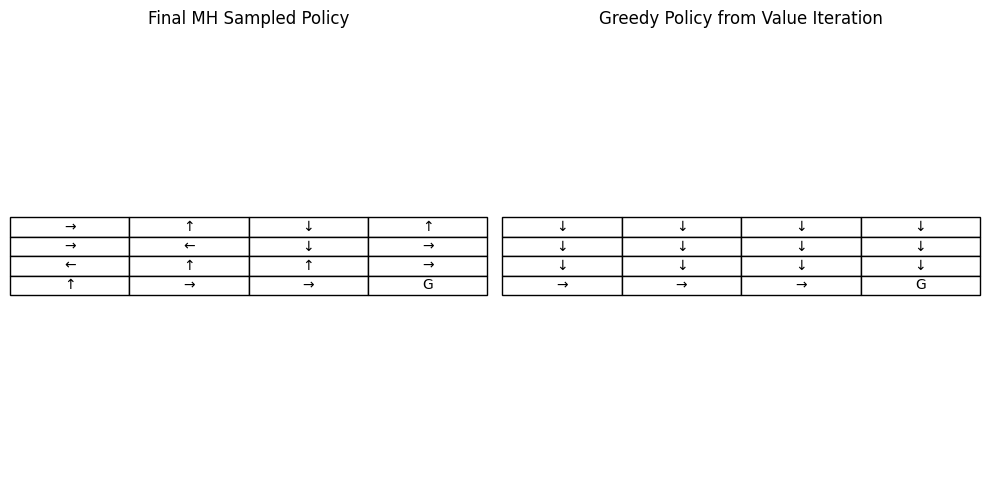

In [7]:
# compare the final policy obtained via Metropolis-Hastings policy sampling with the optimal greedy policy obtained via value iteration:
# --- Value Iteration to find the greedy policy ---
def value_iteration(theta=1e-4):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    while True:
        delta = 0
        for s in range(num_states):
            if s == num_states - 1:
                continue
            q_values = []
            for a in range(num_actions):
                s_next = get_next_state(s, a)
                r = reward_function(s_next)
                q = r + gamma * V[s_next]
                q_values.append(q)
            best_q = max(q_values)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_values)
        if delta < theta:
            break
    return policy

# --- Convert policy index array to arrow grid ---
def greedy_arrows(policy_indices):
    arrows = np.full((grid_size, grid_size), ' ')
    arrow_dict = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    for s in range(num_states):
        x, y = state_to_xy(s)
        if s == num_states - 1:
            arrows[x, y] = 'G'
        else:
            arrows[x, y] = arrow_dict[policy_indices[s]]
    return arrows

# --- Get final MH-sampled policy arrows ---
def policy_arrows(policy_params):
    arrows = np.full((grid_size, grid_size), ' ')
    arrow_dict = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    for s in range(num_states):
        x, y = state_to_xy(s)
        if s == num_states - 1:
            arrows[x, y] = 'G'  # Goal
        else:
            best_action = np.argmax(softmax(policy_params[s]))
            arrows[x, y] = arrow_dict[best_action]
    return arrows

# --- Run value iteration and compare ---
greedy_policy = value_iteration()
greedy_arrows_text = greedy_arrows(greedy_policy)
mh_arrows = policy_arrows(samples[-1])  # Final MH policy

# --- Plot side-by-side comparison ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# MH policy
table1 = axes[0].table(cellText=mh_arrows, loc='center', cellLoc='center')
axes[0].set_title("Final MH Sampled Policy")
axes[0].axis('off')

# Greedy policy
table2 = axes[1].table(cellText=greedy_arrows_text, loc='center', cellLoc='center')
axes[1].set_title("Greedy Policy from Value Iteration")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# --- Extract final MH policy ---
def extract_mh_policy(policy_params):
    return np.array([np.argmax(softmax(policy_params[s])) for s in range(num_states)])

# --- Value iteration to get greedy policy (if not already run) ---
def value_iteration(theta=1e-4):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    while True:
        delta = 0
        for s in range(num_states):
            if s == num_states - 1:
                continue
            q_values = []
            for a in range(num_actions):
                s_next = get_next_state(s, a)
                r = reward_function(s_next)
                q = r + gamma * V[s_next]
                q_values.append(q)
            best_q = max(q_values)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_values)
        if delta < theta:
            break
    return policy

# --- Compare the two policies ---
mh_final_policy = extract_mh_policy(samples[-1])
greedy_policy = value_iteration()

# --- Measure agreement ---
matches = (mh_final_policy == greedy_policy)
match_count = np.sum(matches)
accuracy = match_count / num_states

# --- Print results ---
print(f"Matching states: {match_count} / {num_states}")
print(f"Accuracy: {accuracy:.2%}")

Matching states: 4 / 16
Accuracy: 25.00%


In [ ]:
def metropolis_hastings_irl(expert_traj, iterations=300):
    # Start with a random reward hypothesis
    current = np.random.uniform(-1, 1, size=num_states)
    samples = []

    for _ in range(iterations):
        # Propose new reward by adding Gaussian noise
        proposal = current + np.random.normal(0, 0.1, size=num_states)

        # Compute greedy policy for both current and proposed reward
        current_policy = compute_policy_from_rewards(current)
        proposed_policy = compute_policy_from_rewards(proposal)

        # Likelihood of observing expert trajectory under each policy
        curr_log_like = trajectory_log_likelihood(current_policy, expert_traj)
        prop_log_like = trajectory_log_likelihood(proposed_policy, expert_traj)

        # MH acceptance probability
        alpha = np.exp(min(0, prop_log_like - curr_log_like))
        if np.random.rand() < alpha:
            current = proposal

        samples.append(current.copy())

    return np.array(samples)
def compute_policy_from_rewards(rewards):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    theta = 1e-4
    while True:
        delta = 0
        for s in range(num_states):
            q_vals = []
            for a in range(num_actions):
                s_next = get_next_state(s, a)
                q_vals.append(rewards[s_next] + gamma * V[s_next])
            best_q = max(q_vals)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_vals)
        if delta < theta:
            break
    return policy

def trajectory_log_likelihood(policy, trajectory):
    log_prob = 0
    for s, a in trajectory:
        if policy[s] == a:
            log_prob += 0  # log(1)
        else:
            log_prob += -np.inf  # impossible under this policy
    return log_prob

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assume the following variables are already defined:
# - reward_samples: NumPy array of MH-sampled reward vectors
# - num_states: total number of states (e.g., 16 for a 4x4 grid)

# Compute mean reward per state from the last 100 MH samples
mean_reward_flat = np.mean(reward_samples[-100:], axis=0)
state_indices = np.arange(num_states)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(state_indices, mean_reward_flat, color='orange', edgecolor='black')
plt.xlabel("State Index")
plt.ylabel("Estimated Reward")
plt.title("Estimated Rewards per State via IRL (Metropolis-Hastings)")
plt.xticks(state_indices)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

NameError: name 'reward_samples' is not defined

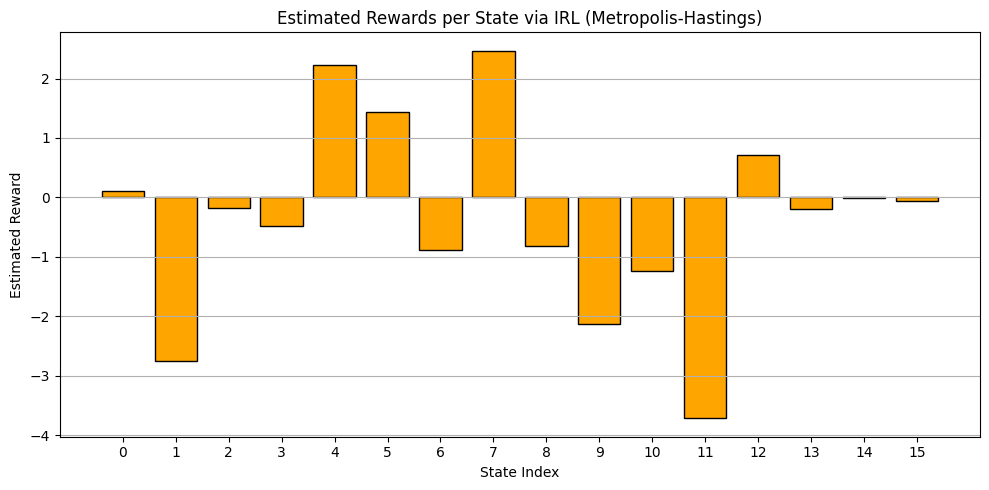

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# GridWorld parameters
grid_size = 4
num_states = grid_size * grid_size
num_actions = 4
gamma = 0.95

# Coordinate mapping
def state_to_xy(s): return divmod(s, grid_size)
def xy_to_state(x, y): return x * grid_size + y

# Deterministic transition
def get_next_state(s, a):
    x, y = state_to_xy(s)
    if a == 0 and x > 0: x -= 1  # up
    elif a == 1 and x < grid_size - 1: x += 1  # down
    elif a == 2 and y > 0: y -= 1  # left
    elif a == 3 and y < grid_size - 1: y += 1  # right
    return xy_to_state(x, y)

# Generate expert trajectory from true reward
def generate_expert_trajectory(rewards, start=0, max_steps=15):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    theta = 1e-4
    while True:
        delta = 0
        for s in range(num_states):
            q_vals = []
            for a in range(num_actions):
                s_next = get_next_state(s, a)
                q_vals.append(rewards[s_next] + gamma * V[s_next])
            best_q = max(q_vals)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_vals)
        if delta < theta:
            break
    trajectory = []
    s = start
    for _ in range(max_steps):
        a = policy[s]
        s_next = get_next_state(s, a)
        trajectory.append((s, a))
        s = s_next
        if s == num_states - 1: break
    return trajectory, policy

# Compute greedy policy from reward
def compute_policy_from_rewards(rewards):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    theta = 1e-4
    while True:
        delta = 0
        for s in range(num_states):
            q_vals = []
            for a in range(num_actions):
                s_next = get_next_state(s, a)
                q_vals.append(rewards[s_next] + gamma * V[s_next])
            best_q = max(q_vals)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_vals)
        if delta < theta:
            break
    return policy

# Log-likelihood of expert trajectory under a policy
def trajectory_log_likelihood(policy, trajectory):
    log_prob = 0
    for s, a in trajectory:
        if policy[s] == a:
            log_prob += 0  # log(1)
        else:
            log_prob += -np.inf  # log(0)
    return log_prob

# MH sampling over reward functions
def metropolis_hastings_irl(expert_traj, iterations=300):
    current = np.random.uniform(-1, 1, size=num_states)
    samples = []
    for _ in range(iterations):
        proposal = current + np.random.normal(0, 0.1, size=num_states)
        current_policy = compute_policy_from_rewards(current)
        proposed_policy = compute_policy_from_rewards(proposal)
        curr_log_like = trajectory_log_likelihood(current_policy, expert_traj)
        prop_log_like = trajectory_log_likelihood(proposed_policy, expert_traj)
        alpha = np.exp(min(0, prop_log_like - curr_log_like))
        if np.random.rand() < alpha:
            current = proposal
        samples.append(current.copy())
    return np.array(samples)

# Define true reward function
true_rewards = -1.0 * np.ones(num_states)
true_rewards[-1] = 1.0  # goal state

# Generate expert behavior
expert_traj, expert_policy = generate_expert_trajectory(true_rewards)

# Run IRL
reward_samples = metropolis_hastings_irl(expert_traj, iterations=300)
mean_reward_flat = np.mean(reward_samples[-100:], axis=0)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(np.arange(num_states), mean_reward_flat, color='orange', edgecolor='black')
plt.xlabel("State Index")
plt.ylabel("Estimated Reward")
plt.title("Estimated Rewards per State via IRL (Metropolis-Hastings)")
plt.xticks(np.arange(num_states))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

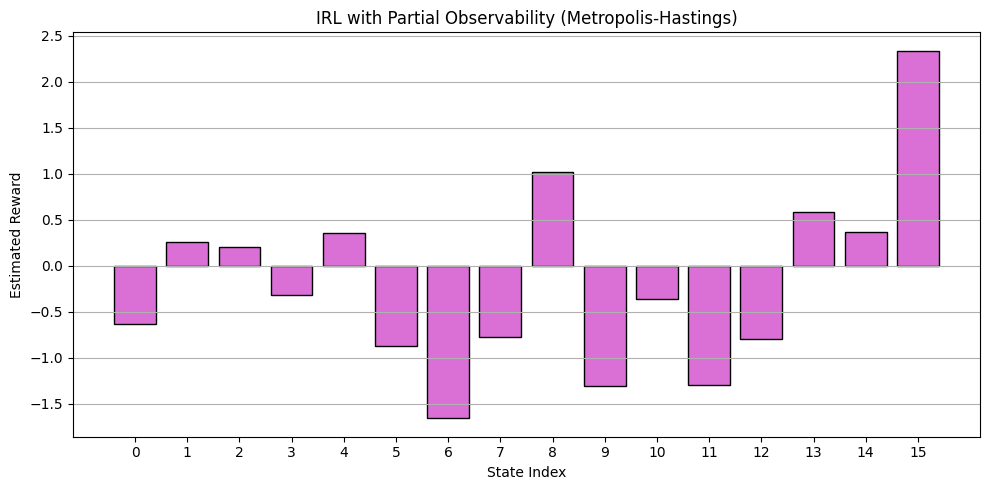

In [11]:
# partial observality

import numpy as np
import matplotlib.pyplot as plt

# Parameters
grid_size = 4
num_states = grid_size * grid_size
num_actions = 4
gamma = 0.95
obs_noise = 0.2  # Probability that observation is wrong

# Helpers for state representation
def state_to_xy(s): return divmod(s, grid_size)
def xy_to_state(x, y): return x * grid_size + y

# Deterministic transition model
def get_next_state(s, a):
    x, y = state_to_xy(s)
    if a == 0 and x > 0: x -= 1  # up
    elif a == 1 and x < grid_size - 1: x += 1  # down
    elif a == 2 and y > 0: y -= 1  # left
    elif a == 3 and y < grid_size - 1: y += 1  # right
    return xy_to_state(x, y)

# Noisy observation function
def observe_state(s):
    if np.random.rand() < obs_noise:
        return np.random.choice([i for i in range(num_states) if i != s])
    return s

# Generate expert trajectory using true reward (observations are noisy)
def generate_noisy_expert_trajectory(rewards, start=0, max_steps=15):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    theta = 1e-4
    while True:
        delta = 0
        for s in range(num_states):
            q_vals = [rewards[get_next_state(s, a)] + gamma * V[get_next_state(s, a)] for a in range(num_actions)]
            best_q = max(q_vals)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_vals)
        if delta < theta:
            break

    trajectory = []
    s = start
    for _ in range(max_steps):
        a = policy[s]
        s_next = get_next_state(s, a)
        obs = observe_state(s)
        trajectory.append((obs, a))
        s = s_next
        if s == num_states - 1: break
    return trajectory

# Compute greedy policy given reward
def compute_policy_from_rewards(rewards):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    theta = 1e-4
    while True:
        delta = 0
        for s in range(num_states):
            q_vals = [rewards[get_next_state(s, a)] + gamma * V[get_next_state(s, a)] for a in range(num_actions)]
            best_q = max(q_vals)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_vals)
        if delta < theta:
            break
    return policy

# Soft likelihood function: allows some error
def soft_trajectory_likelihood(policy, trajectory, epsilon=0.1):
    log_prob = 0
    for obs, a in trajectory:
        p = epsilon / num_actions
        if policy[obs] == a:
            p += 1 - epsilon
        log_prob += np.log(p)
    return log_prob

# Metropolis-Hastings reward sampling
def metropolis_hastings_irl_partial_obs(expert_traj, iterations=300):
    current = np.random.uniform(-1, 1, size=num_states)
    samples = []
    for _ in range(iterations):
        proposal = current + np.random.normal(0, 0.1, size=num_states)
        current_policy = compute_policy_from_rewards(current)
        proposed_policy = compute_policy_from_rewards(proposal)
        curr_log_like = soft_trajectory_likelihood(current_policy, expert_traj)
        prop_log_like = soft_trajectory_likelihood(proposed_policy, expert_traj)
        alpha = np.exp(min(0, prop_log_like - curr_log_like))
        if np.random.rand() < alpha:
            current = proposal
        samples.append(current.copy())
    return np.array(samples)

# Define true reward and simulate expert behavior
true_rewards = -1.0 * np.ones(num_states)
true_rewards[-1] = 1.0  # goal state
expert_traj = generate_noisy_expert_trajectory(true_rewards)

# Run IRL
reward_samples = metropolis_hastings_irl_partial_obs(expert_traj, iterations=300)
mean_reward_flat = np.mean(reward_samples[-100:], axis=0)

# Plot result
plt.figure(figsize=(10, 5))
plt.bar(np.arange(num_states), mean_reward_flat, color='orchid', edgecolor='black')
plt.xlabel("State Index")
plt.ylabel("Estimated Reward")
plt.title("IRL with Partial Observability (Metropolis-Hastings)")
plt.xticks(np.arange(num_states))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

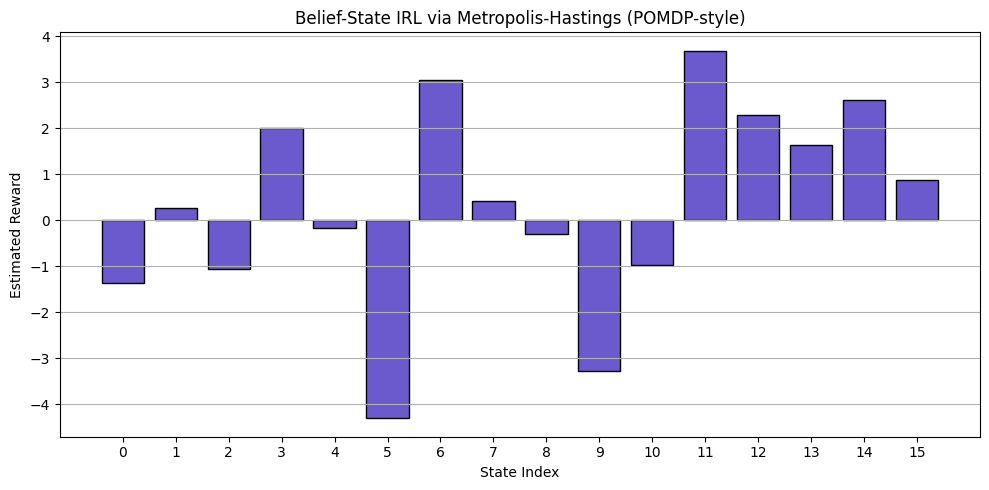

In [12]:
#Here’s the full Python code for Inverse Reinforcement Learning (IRL) in a partially observable GridWorld using Metropolis-Hastings sampling with belief-state tracking (POMDP-style inference):
import numpy as np
import matplotlib.pyplot as plt

# GridWorld parameters
grid_size = 4
num_states = grid_size * grid_size
num_actions = 4
gamma = 0.95
obs_noise = 0.2  # Observation noise
belief_epsilon = 1e-8

# Helpers
def state_to_xy(s): return divmod(s, grid_size)
def xy_to_state(x, y): return x * grid_size + y

def get_next_state(s, a):
    x, y = state_to_xy(s)
    if a == 0 and x > 0: x -= 1
    elif a == 1 and x < grid_size - 1: x += 1
    elif a == 2 and y > 0: y -= 1
    elif a == 3 and y < grid_size - 1: y += 1
    return xy_to_state(x, y)

# Observation model
def obs_prob(o, s):
    return 1 - obs_noise if o == s else obs_noise / (num_states - 1)

# Belief update using Bayes rule
def update_belief(prior, action, observation):
    posterior = np.zeros(num_states)
    for s_prime in range(num_states):
        for s in range(num_states):
            if get_next_state(s, action) == s_prime:
                posterior[s_prime] += prior[s]
        posterior[s_prime] *= obs_prob(observation, s_prime)
    posterior += belief_epsilon
    posterior /= np.sum(posterior)
    return posterior

# Expert trajectory generation using belief tracking
def generate_expert_belief_trajectory(rewards, start=0, max_steps=15):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    theta = 1e-4
    while True:
        delta = 0
        for s in range(num_states):
            q_vals = [rewards[get_next_state(s, a)] + gamma * V[get_next_state(s, a)] for a in range(num_actions)]
            best_q = max(q_vals)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_vals)
        if delta < theta:
            break

    belief = np.zeros(num_states)
    belief[start] = 1.0
    s = start
    trajectory = []

    for _ in range(max_steps):
        most_likely_state = np.argmax(belief)
        a = policy[most_likely_state]
        s_next = get_next_state(s, a)
        obs = s_next if np.random.rand() > obs_noise else np.random.choice([i for i in range(num_states) if i != s_next])
        trajectory.append((belief.copy(), a))
        belief = update_belief(belief, a, obs)
        s = s_next
        if s == num_states - 1: break
    return trajectory

# Compute greedy policy from reward
def compute_policy_from_rewards(rewards):
    V = np.zeros(num_states)
    policy = np.zeros(num_states, dtype=int)
    theta = 1e-4
    while True:
        delta = 0
        for s in range(num_states):
            q_vals = [rewards[get_next_state(s, a)] + gamma * V[get_next_state(s, a)] for a in range(num_actions)]
            best_q = max(q_vals)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
            policy[s] = np.argmax(q_vals)
        if delta < theta:
            break
    return policy

# Soft likelihood using belief-weighted action probabilities
def soft_belief_likelihood(policy, belief_trajectory, epsilon=0.1):
    log_prob = 0
    for belief, a in belief_trajectory:
        prob = 0
        for s in range(num_states):
            p = epsilon / num_actions
            if policy[s] == a:
                p += 1 - epsilon
            prob += belief[s] * p
        log_prob += np.log(prob + belief_epsilon)
    return log_prob

# MH sampler for IRL with belief state
def metropolis_hastings_irl_belief(expert_traj, iterations=300):
    current = np.random.uniform(-1, 1, size=num_states)
    samples = []
    for _ in range(iterations):
        proposal = current + np.random.normal(0, 0.1, size=num_states)
        current_policy = compute_policy_from_rewards(current)
        proposed_policy = compute_policy_from_rewards(proposal)
        curr_log_like = soft_belief_likelihood(current_policy, expert_traj)
        prop_log_like = soft_belief_likelihood(proposed_policy, expert_traj)
        alpha = np.exp(min(0, prop_log_like - curr_log_like))
        if np.random.rand() < alpha:
            current = proposal
        samples.append(current.copy())
    return np.array(samples)

# Setup true reward and generate expert trajectory
true_rewards = -1.0 * np.ones(num_states)
true_rewards[-1] = 1.0
expert_traj = generate_expert_belief_trajectory(true_rewards)

# Run MH-IRL with belief states
reward_samples = metropolis_hastings_irl_belief(expert_traj, iterations=300)
mean_reward_flat = np.mean(reward_samples[-100:], axis=0)

# Plot estimated reward histogram
plt.figure(figsize=(10, 5))
plt.bar(np.arange(num_states), mean_reward_flat, color='slateblue', edgecolor='black')
plt.xlabel("State Index")
plt.ylabel("Estimated Reward")
plt.title("Belief-State IRL via Metropolis-Hastings (POMDP-style)")
plt.xticks(np.arange(num_states))
plt.grid(axis='y')
plt.tight_layout()
plt.show()